# EA x DKSG
**classification: web scrape**

classify organizations into cause areas based on descriptions
- basically, descriptions -> cause areas

## methodology
- clean up organization descriptions
    - drop stopwords
    - drop punctuations
    - lemmatize words
- create count vectors for each description
- use count vectors as feature for classification with
    - decision trees
    - random forest regressor
    
## hypothesis
an organization with certain keywords in its description should be involved in a cause area if the keywords match up with the keywords defined in the cause area

## clean up organization descriptions

In [1]:
## setup
%run env_setup.py
%run filepaths.py
%run helpers.py

In [2]:
web_df = read_from_csv(WEB_SCRAPE_CSV)

In [3]:
web_df.head()

,key,name,description,website,cause_area,programme_types,address,country,city,contact_number,...,Charity.Status,Date.of.Charity.Registration,IPC.Status,IPC.Period,Details.URL,fax,revenue,employees,lat,lon
0,1,Bali Pink Ribbon - Breast Cancer Awareness Fou...,"Bali Pink Ribbon was founded by Gaye Warren, a...",http://www.balipinkribbon.com,"Balinese People, Health",Our vision is to prevent Indonesian women from...,80113 Dauh Puri Kauh (Denpasar Barat),indonesia,Denpasar,+62 361 4746238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.673612,115.203737
1,2,Volunteer Programs Bali,"At VP Bali, we believe that education can chan...",http://http://volunteerprogramsbali.org,"Balinese People, Children, Balinese Art & Culture",A dopting the Balinese values and its premise ...,80571 Ubud (Petulu),indonesia,Ubud,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.675090,115.189919
2,3,NGO 4 Ger,Only for specials,http://www.fiedbeck.de,Balinese People,NaN,Strasse 1 Bali,indonesia,Amed,+49 7531 123456,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.409518,115.188916
3,4,Bali Children Foundation,"Our vision, at Bali Children Foundation, is to...",http://www.balichildrenfoundation.org,"Children, Education & Schools",To provide community education in remote areas...,"Jl. Raya Kesambi No.369, Kerobokan, Kuta Utara...",indonesia,Seminyak,+62 361 847 5399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.653567,115.172545
4,5,Friends of the National Parks Foundation,Friends of the National Park Foundation (FNPF)...,http://www.fnpf.org,Environment & Nature Conservation,"To protect wildlife and its habitat, at the sa...","Ped, Nusapenida, Klungkung Regency, Bali 80771...",indonesia,Pejeng,+62 361 4792286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.683880,115.518827


In [4]:
## fill up empty descriptions
web_df['description'] = web_df['description'].fillna('')

## add cleaned description
web_df['desc_clean_words'] = get_cleaned_descriptions(list(web_df['description']), True, True, True)
web_df['desc_clean'] = get_sentence_from_list(list(web_df['desc_clean_words']))

In [5]:
## add cleaned cause areas
def clean_cause_area(cause_area_raw):
    words = cause_area_raw.lower().split(",")
    words = [w.strip() for w in words]
    words = [w for w in words if len(w) > 0]
    return set(words)

web_df['cause_area'] = web_df['cause_area'].fillna('')
web_df['cause_area_clean'] = web_df['cause_area'].apply(clean_cause_area)

In [6]:
web_df[['desc_clean_words', 'desc_clean', 'cause_area_clean']].head()

,desc_clean_words,desc_clean,cause_area_clean
0,"[bali, pink, ribbon, found, gaye, warren, brit...",bali pink ribbon found gaye warren british bre...,"{balinese people, health}"
1,"[at, vp, bali, believe, education, change, chi...",at vp bali believe education change childã¢ââ...,"{children, balinese art & culture, balinese pe..."
2,"[only, special]",only special,{balinese people}
3,"[our, vision, bali, children, foundation, prov...",our vision bali children foundation provide ed...,"{education & schools, children}"
4,"[friends, national, park, foundation, fnpf, in...",friends national park foundation fnpf indonesi...,{environment & nature conservation}


## basic viz

In [12]:
%matplotlib inline
%run viz_setup.py

#### cause areas (web scraped)

In [13]:
from itertools import chain
def get_web_cause_area_summary(web_df):
    df = list(chain.from_iterable(list(web_df['cause_area_clean'].apply(lambda s: list(s)))))
    df = pd.Series(df) 
    df = pd.DataFrame(df.value_counts().reset_index())
    df.columns = ['cause area', 'count']
    
    total_cause_area_count = sum(df['count'])
    df['%'] = df['count'].apply(lambda count: count/total_cause_area_count)
    
    return df

web_cause_area_df = get_web_cause_area_summary(web_df)

Q: top 20 cause areas with highest counts

In [14]:
web_cause_area_df[:20]

,cause area,count,%
0,religious,1085,0.144052
1,education,463,0.061471
2,social and welfare,392,0.052045
3,health,281,0.037307
4,children,251,0.033324
5,charitable,242,0.032130
6,others,232,0.030802
7,environment,225,0.029873
8,support groups,214,0.028412
9,arts and heritage,147,0.019517


Q: cause area by counts bar chart (all)

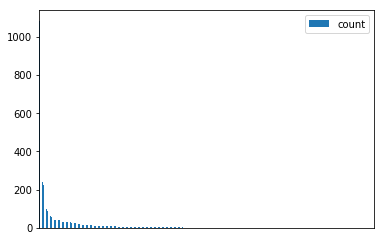

In [15]:
plt = web_cause_area_df.plot.bar(x='cause area', y='count')
plt.xaxis.set_visible(False)

Q: cause area by counts bar chart (top 20)

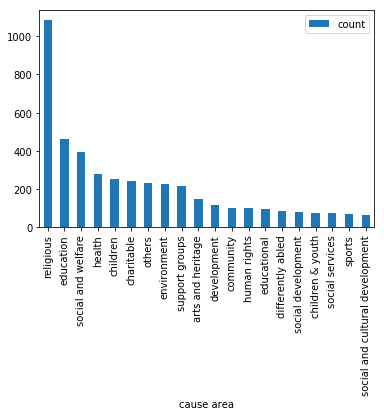

In [16]:
plt = web_cause_area_df[:20].plot.bar(x='cause area', y='count')
plt

Q: total number of unique cause areas

In [17]:
len(web_cause_area_df)

586

Q: total number of organization

In [18]:
sum(web_cause_area_df['count'])

7532

## create features: count vectors for each description
- take top 20 web_cause_areas by count

In [19]:
## ml setup
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import tree
from sklearn import ensemble
from sklearn.metrics import accuracy_score

#### select top 20 cause areas (web scrape)

Q: top 20 cause areas

In [20]:
web_cause_area_select = web_cause_area_df[:20]
set(web_cause_area_select['cause area'])

{'arts and heritage',
 'charitable',
 'children',
 'children & youth',
 'community',
 'development',
 'differently abled',
 'education',
 'educational',
 'environment',
 'health',
 'human rights',
 'others',
 'religious',
 'social and cultural development',
 'social and welfare',
 'social development',
 'social services',
 'sports',
 'support groups'}

Q: proportion of top 20 web cause areas (against all counts)

In [21]:
sum(web_cause_area_select['%'])

0.58271375464684005

create cause_area_clean_filter (ie. a copy of cause_area_clean with only filtered matches)

In [22]:
web_df['cause_area_clean_filter'] = \
    web_df['cause_area_clean'].apply(lambda c: c.intersection(set(web_cause_area_select['cause area'])))

#### select orgs in selected cause areas

In [23]:
def select_orgs_in_cause_area(df, cause_areas):
    matched_indexes = df['cause_area_clean'] \
        .apply(lambda c: len(c.intersection(cause_areas))) \
        .where(lambda count: count > 1) \
        .dropna() \
        .index
    return df.iloc[matched_indexes]

web_df_select = select_orgs_in_cause_area(web_df, set(web_cause_area_select['cause area']))

In [24]:
web_df_select.head()

,key,name,description,website,cause_area,programme_types,address,country,city,contact_number,...,Details.URL,fax,revenue,employees,lat,lon,desc_clean_words,desc_clean,cause_area_clean,cause_area_clean_filter
9,10,Kupu Kupu Foundation Indonesia,We help improve lives by assisting with medica...,http://www.kupukupufoundation.org,"Children, Health, Education & Schools",Kupu-Kupu Foundation improves the lives of peo...,"Jl. Tirta Tawar No.22, Ubud, Kabupaten Gianyar...",indonesia,Ubud,+62 812 3628720,...,NaN,NaN,NaN,NaN,-8.506246,115.268599,"[we, help, improve, live, assist, medical, car...",we help improve live assist medical care medic...,"{education & schools, children, health}","{children, health}"
10,11,Yayasan Solemen Indonesia,"Yayasan Solemen Indonesia, an Indonesian regis...",http://www.solemen.org,"Balinese People, Children, Health, General Wel...",Our mission is to help the disadvantaged in Ba...,"80363, Jl. Danau Poso No.55, Sanur Kauh, South...",indonesia,Kuta,+62 0812 3720 6220,...,NaN,NaN,NaN,NaN,-8.705537,115.252546,"[yayasan, solemen, indonesia, indonesian, regi...",yayasan solemen indonesia indonesian register ...,"{children, balinese people, health, general we...","{children, health}"
14,15,Fair Future Foundation,Free healthcare for people in need,http://www.fairfuturefoundation.org,"Balinese People, Children, Health, General Wel...",to improve the daily life of the local communi...,"Jalan Sriwedari 6, Taman Kaja, Ubud, Bali 8051...",indonesia,Ubud,+62 361 975370,...,NaN,NaN,NaN,NaN,-8.507416,115.265190,"[free, healthcare, people, need]",free healthcare people need,"{children, balinese people, health, general we...","{children, health}"
26,27,Yayasan Kemanusiaan Ibu Pertiwi,YKIP (Yayasan Kemanusiaan Ibu Pertiwi) or the ...,http://www.ykip.org,"Children, Health, Education & Schools",Our mission is to restore vision. Our vision i...,"Jalan By Pass Ngurah Rai, Gang Mina Utama No.1...",indonesia,Tuban,+62 361 761208,...,NaN,NaN,NaN,NaN,-8.715940,115.220705,"[ykip, yayasan, kemanusiaan, ibu, pertiwi, hum...",ykip yayasan kemanusiaan ibu pertiwi humanitar...,"{education & schools, children, health}","{children, health}"
2557,2558,MÃ¢ÂÂLop Tapang,M'lop Tapang is a comprehensive center dedicat...,NaN,"Education, Health, Economic Empowerment, Right...",NaN,NaN,cambodia,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[m'lop, tapang, comprehensive, center, dedicat...",m'lop tapang comprehensive center dedicate dis...,"{rights protection, economic empowerment, heal...","{health, education}"


Q: total number of organizations after filtering

In [25]:
len(web_df_select)

258

#### split train/test/validation

In [26]:
train_ratio, test_ratio, validation_ratio_from_test = (0.7,0.3,0.5)

In [27]:
def do_train_test_validation_split(df, train_ratio, test_ratio, validation_ratio_from_test, random_state=None):
    train_data, test_data = \
        train_test_split(df, train_size=train_ratio, test_size=test_ratio, random_state=random_state)
    validation_data, test_data = \
        train_test_split(test_data, train_size=validation_ratio_from_test, 
                          test_size=1-validation_ratio_from_test, random_state=random_state)
            
    return train_data, test_data, validation_data
    
train_data, test_data, validation_data = \
    do_train_test_validation_split(web_df_select, train_ratio, test_ratio, validation_ratio_from_test, 1)

train/test/validation counts

In [28]:
print("train count: %d" % len(train_data))
print("test count: %d" % len(test_data))
print("validation count: %d" % len(validation_data));

train count: 180
test count: 39
validation count: 39


#### encode org descriptions using CountVectorizer

In [77]:
count_vectorizer = CountVectorizer(max_features=100)

train_data_feat = count_vectorizer.fit_transform(train_data['desc_clean'])
test_data_feat = count_vectorizer.transform(test_data['desc_clean'])
validation_data_feat = count_vectorizer.transform(test_data['desc_clean'])

## create labels: cause area categories
#### encode cause area categories to multi-label

In [30]:
mlb = MultiLabelBinarizer()
mlb.fit([web_cause_area_select['cause area']])
mlb.classes_

array(['arts and heritage', 'charitable', 'children', 'children & youth',
       'community', 'development', 'differently abled', 'education',
       'educational', 'environment', 'health', 'human rights', 'others',
       'religious', 'social and cultural development',
       'social and welfare', 'social development', 'social services',
       'sports', 'support groups'], dtype=object)

In [31]:
validation_data.head()

,key,name,description,website,cause_area,programme_types,address,country,city,contact_number,...,Details.URL,fax,revenue,employees,lat,lon,desc_clean_words,desc_clean,cause_area_clean,cause_area_clean_filter
3324,3325,ABCs and Rice,Being a Kid Is Their Job: ABCs and Rice is a s...,NaN,"Children, Education, Hunger",NaN,NaN,cambodia,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[being, kid, is, their, job, abcs, rice, schoo...",being kid is their job abcs rice school provid...,"{hunger, children, education}","{children, education}"
10561,10562,Thai Mueang Volunteers,Thai Mueang Volunteers work very closely with ...,http://www.tmvolunteers.org/,"Children,Community Service,Educational,",NaN,NaN,thailand,Thai Mueang,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[thai, mueang, volunteers, work, closely, scho...",thai mueang volunteers work closely school hea...,"{community service, educational, children}","{educational, children}"
10234,10235,"Kalinangan Youth Foundation, Inc.",Company Description:\nThe Kalinangan Youth Fou...,NaN,"Charitable,Social Development",NaN,"Rm. 202 Alexander House, 132 Amorsolo St., Leg...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,14.554705,121.015068,"[company, description, \n, the, kalinangan, yo...",company description \n the kalinangan youth fo...,"{charitable, social development}","{charitable, social development}"
3391,3392,For Vietnamese Stature Foundation,Daily School Milk for 300 Poor Children in Vie...,NaN,"Children, HumanÃÂ Rights, Hunger, HumanÃÂ Ri...",NaN,NaN,vietnam,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"[daily, school, milk, 300, poor, children, vie...",daily school milk 300 poor children vietnam th...,"{children, humanãâ rights, womenãâ andãâ gi...","{children, health}"
10306,10307,Ramon Magsaysay Award Foundation,Company Description:\nThe Ramon Magsaysay Awar...,rmaf.org.ph,"Charitable,Social Development",NaN,"G/F Ramon Magsaysay Center, 1680 Roxas Blvd. C...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-22.139555,17.222061,"[company, description, \n, the, ramon, magsays...",company description \n the ramon magsaysay awa...,"{charitable, social development}","{charitable, social development}"


In [32]:
train_data_label = mlb.transform(train_data['cause_area_clean_filter'])
test_data_label = mlb.transform(test_data['cause_area_clean_filter'])
validation_data_label = mlb.transform(validation_data['cause_area_clean_filter'])

## classify orgs

In [33]:
base_clf = ensemble.RandomForestClassifier(n_estimators=25, n_jobs=-1)
base_clf = base_clf.fit(train_data_feat, train_data_label)
test_predict = base_clf.predict(test_data_feat)
train_predict = base_clf.predict(train_data_feat)
validation_predict = base_clf.predict(validation_data_feat)

## classifier performance

In [34]:
## accuracy helper
def get_accuracy(true_labels, predicted_labels):
    accuracies = {}
    
    predicted_classes = list(mlb.classes_)
    for cause_area in web_cause_area_select['cause area']:
        index = predicted_classes.index(cause_area)
        accuracy = accuracy_score(
            [a[index] for a in true_labels],
            [a[index] for a in predicted_labels]
        )
        accuracies[cause_area] = accuracy
        
    return accuracies

on train data

In [67]:
pre_optimization_train_acc = get_accuracy(train_data_label, train_predict)
pre_optimization_train_acc

{'arts and heritage': 1.0,
 'charitable': 1.0,
 'children': 1.0,
 'children & youth': 1.0,
 'community': 1.0,
 'development': 1.0,
 'differently abled': 1.0,
 'education': 1.0,
 'educational': 0.99444444444444446,
 'environment': 1.0,
 'health': 1.0,
 'human rights': 1.0,
 'others': 1.0,
 'religious': 1.0,
 'social and cultural development': 1.0,
 'social and welfare': 1.0,
 'social development': 1.0,
 'social services': 1.0,
 'sports': 1.0,
 'support groups': 1.0}

on test data

In [68]:
get_accuracy(test_data_label, test_predict)

{'arts and heritage': 1.0,
 'charitable': 1.0,
 'children': 0.76923076923076927,
 'children & youth': 1.0,
 'community': 0.89743589743589747,
 'development': 1.0,
 'differently abled': 1.0,
 'education': 0.84615384615384615,
 'educational': 0.71794871794871795,
 'environment': 0.76923076923076927,
 'health': 0.84615384615384615,
 'human rights': 0.92307692307692313,
 'others': 1.0,
 'religious': 0.94871794871794868,
 'social and cultural development': 1.0,
 'social and welfare': 1.0,
 'social development': 0.92307692307692313,
 'social services': 1.0,
 'sports': 1.0,
 'support groups': 1.0}

on validation data (but **not** used as metric, since it will be used for next section)

In [69]:
pre_optimization_validation_acc = get_accuracy(validation_data_label, validation_predict)
pre_optimization_validation_acc

{'arts and heritage': 1.0,
 'charitable': 0.33333333333333331,
 'children': 0.38461538461538464,
 'children & youth': 1.0,
 'community': 0.94871794871794868,
 'development': 1.0,
 'differently abled': 1.0,
 'education': 0.48717948717948717,
 'educational': 0.5641025641025641,
 'environment': 0.89743589743589747,
 'health': 0.71794871794871795,
 'human rights': 0.97435897435897434,
 'others': 1.0,
 'religious': 1.0,
 'social and cultural development': 1.0,
 'social and welfare': 1.0,
 'social development': 0.53846153846153844,
 'social services': 1.0,
 'sports': 1.0,
 'support groups': 1.0}

Q: mean train/test/validation accuracies

In [76]:
print('mean train acc: %f' % np.average(list(pre_optimization_train_acc.values())))
print('mean test acc: %f' % np.average(list(get_accuracy(test_data_label, test_predict).values())))
print('mean validation acc: %f' % np.average(list(pre_optimization_validation_acc.values())))

mean train acc: 0.999722
mean test acc: 0.932051
mean validation acc: 0.842308


## classification (optimization)
improve model performance on test/validation data
- since model does very well on train data, we don't need a more complex model
- however, since test accuracy is far lower than train accuracy, model is overfitting
- thus, reduce overfitting by optimizing model hyperparameters
- use grid search to find best model hyperparameters

#### complexity of current model
random forest classifier parameters

In [39]:
base_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

1st decision tree's parameters

In [40]:
base_clf.estimators_[0]

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1594069210, splitter='best')

max_depth and node_count of all decision trees

In [41]:
def get_random_tree_statistics(random_tree):
    def get_attributes(tree):
        return {
            'max_depth': tree.max_depth,
            'node_count': tree.node_count,
        }
    
    return [get_attributes(t.tree_) for t in random_tree.estimators_]

base_clf_statistics = get_random_tree_statistics(base_clf)
base_clf_statistics

[{'max_depth': 13, 'node_count': 141},
 {'max_depth': 15, 'node_count': 143},
 {'max_depth': 11, 'node_count': 139},
 {'max_depth': 17, 'node_count': 131},
 {'max_depth': 18, 'node_count': 123},
 {'max_depth': 15, 'node_count': 139},
 {'max_depth': 16, 'node_count': 145},
 {'max_depth': 16, 'node_count': 135},
 {'max_depth': 13, 'node_count': 147},
 {'max_depth': 16, 'node_count': 133},
 {'max_depth': 14, 'node_count': 147},
 {'max_depth': 18, 'node_count': 125},
 {'max_depth': 13, 'node_count': 145},
 {'max_depth': 16, 'node_count': 137},
 {'max_depth': 14, 'node_count': 147},
 {'max_depth': 11, 'node_count': 137},
 {'max_depth': 14, 'node_count': 159},
 {'max_depth': 18, 'node_count': 135},
 {'max_depth': 13, 'node_count': 139},
 {'max_depth': 15, 'node_count': 137},
 {'max_depth': 18, 'node_count': 133},
 {'max_depth': 17, 'node_count': 131},
 {'max_depth': 15, 'node_count': 139},
 {'max_depth': 18, 'node_count': 129},
 {'max_depth': 17, 'node_count': 131}]

Q: median tree max depth

In [42]:
np.median([x['max_depth'] for x in base_clf_statistics])

15.0

Q: median tree node count

In [43]:
np.median([x['node_count'] for x in base_clf_statistics])

137.0

#### bounds and parameters for grid search
since the objective is to reduce model complexity, the following parameters can be explored to find the best hyperparameters for the model
- n_estimators (5-50, increments of 5): lower = less overfitting
- max_depth (5-20): lower = less overfitting
- min_samples_leaf (1-10): higher = less overfitting
- min_samples_split (2-10): higher = less overfitting

In [44]:
n_estimators_range = range(5,50+1,10)
max_depth_range = range(5,20+1)
min_samples_leaf_range = range(1,10+1)
min_samples_split_range = range(2,10+1)

generate hyperparameters

In [45]:
from collections import namedtuple
import random

dt_hyperparameters = namedtuple('hyperparameters','n_estimators max_depth min_samples_leaf min_samples_split')
def create_dt_hyperparameters():
    return dt_hyperparameters(
        random.choice(n_estimators_range),
        random.choice(max_depth_range),
        random.choice(min_samples_leaf_range),
        random.choice(min_samples_split_range),
    )

dt_hyperparameters_list = [create_dt_hyperparameters() for x in range(1,100)]
dt_hyperparameters_list[:5]

[hyperparameters(n_estimators=45, max_depth=15, min_samples_leaf=6, min_samples_split=9),
 hyperparameters(n_estimators=25, max_depth=13, min_samples_leaf=10, min_samples_split=7),
 hyperparameters(n_estimators=5, max_depth=17, min_samples_leaf=10, min_samples_split=6),
 hyperparameters(n_estimators=45, max_depth=19, min_samples_leaf=4, min_samples_split=6),
 hyperparameters(n_estimators=15, max_depth=15, min_samples_leaf=3, min_samples_split=5)]

define classify function for hyperameter search

In [46]:
def do_classify(model_params):
    clf = ensemble.RandomForestClassifier(
        n_estimators = model_params.n_estimators,
        max_depth = model_params.max_depth,
        min_samples_leaf = model_params.min_samples_leaf,
        min_samples_split = model_params.min_samples_split,
        n_jobs = -1)
    clf = clf.fit(train_data_feat, train_data_label)
    
    test_predict = clf.predict(test_data_feat)
    train_predict = clf.predict(train_data_feat)
    validation_predict = clf.predict(validation_data_feat)
    
    train_acc = get_accuracy(train_data_label, train_predict)
    test_acc = get_accuracy(test_data_label, test_predict)
    validation_acc = get_accuracy(validation_data_label, validation_predict)
    
    return {
        'model_params': model_params,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'validation_acc': validation_acc,
        'mean_train_acc': np.average(list(train_acc.values())),
        'mean_test_acc': np.average(list(test_acc.values())),
        'mean_validation_acc': np.average(list(validation_acc.values())),
        'clf': clf,
    }

do hyperparameter search

In [47]:
experiment_results = [do_classify(params) for params in dt_hyperparameters_list]

get hyperparameters with best mean test performance
- ie. using test set to optimize hyperparameters

In [48]:
top_hyperparameter = sorted(experiment_results, reverse=False, key=lambda e: e['mean_test_acc'])[0]
print("top hyperparameters: ", top_hyperparameter['model_params'])
print("mean train accuracy: %f" % top_hyperparameter['mean_train_acc'])
print("mean test accuracy: %f" % top_hyperparameter['mean_test_acc'])

top hyperparameters:  hyperparameters(n_estimators=5, max_depth=14, min_samples_leaf=1, min_samples_split=3)
mean train accuracy: 0.988611
mean test accuracy: 0.915385


mean validation accuracy of model (ie. actual performance of model on unseen data)

In [49]:
print("mean validation accuracy: %f" % top_hyperparameter['mean_validation_acc'])

mean validation accuracy: 0.851282


## predict descriptions with fully trained model

train random forest classifier with top hyperparameters and with all data

In [50]:
def train_best_clf(model_params):
    best_clf = ensemble.RandomForestClassifier(
        n_estimators = model_params.n_estimators,
        max_depth = model_params.max_depth,
        min_samples_leaf = model_params.min_samples_leaf,
        min_samples_split = model_params.min_samples_split,
        n_jobs = -1)

    best_clf.fit(train_data_feat, train_data_label)
    best_clf.fit(test_data_feat, test_data_label)
    best_clf.fit(validation_data_feat, validation_data_label)
    
    return best_clf

best_clf = train_best_clf(top_hyperparameter['model_params'])

predict descriptions of all entries (including organizations used for train/test/validation)

In [51]:
best_countvectorizer = CountVectorizer(max_features=100)
count_vectorizer.fit(train_data['desc_clean'])
count_vectorizer.fit(test_data['desc_clean'])
count_vectorizer.fit(test_data['desc_clean'])

def do_predict_cause_area_on_descriptions(df):
    descriptions = best_countvectorizer.fit_transform(df['desc_clean'])
    predictions_raw = best_clf.predict(descriptions)
    predictions = mlb.inverse_transform(predictions_raw)
    return [set(s) for s in predictions]
    
web_df['cause_area_predict'] = do_predict_cause_area_on_descriptions(web_df)

Q: number of organizations with at least one predicted cause area

In [52]:
len(web_df['cause_area_predict'].apply(lambda s: s if len(s) > 0 else None).dropna())

13636

define new row that uses predicted cause areas, and overwrites predicted cause areas if the 'ground truth' cause area is present

In [61]:
web_df['cause_area_predict_final'] = web_df['cause_area_predict']

orgs_with_filtered_cause_areas = \
    web_df['cause_area_clean_filter'].apply(lambda s: s if len(s) > 0 else None).dropna().index
web_df['cause_area_predict_final'].loc[orgs_with_filtered_cause_areas] = \
    web_df['cause_area_clean_filter'].loc[orgs_with_filtered_cause_areas]
    
web_df.head()

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,key,name,description,website,cause_area,programme_types,address,country,city,contact_number,...,revenue,employees,lat,lon,desc_clean_words,desc_clean,cause_area_clean,cause_area_clean_filter,cause_area_predict,cause_area_predict_final
0,1,Bali Pink Ribbon - Breast Cancer Awareness Fou...,"Bali Pink Ribbon was founded by Gaye Warren, a...",http://www.balipinkribbon.com,"Balinese People, Health",Our vision is to prevent Indonesian women from...,80113 Dauh Puri Kauh (Denpasar Barat),indonesia,Denpasar,+62 361 4746238,...,NaN,NaN,-8.673612,115.203737,"[bali, pink, ribbon, found, gaye, warren, brit...",bali pink ribbon found gaye warren british bre...,"{balinese people, health}",{health},"{charitable, educational}",{health}
1,2,Volunteer Programs Bali,"At VP Bali, we believe that education can chan...",http://http://volunteerprogramsbali.org,"Balinese People, Children, Balinese Art & Culture",A dopting the Balinese values and its premise ...,80571 Ubud (Petulu),indonesia,Ubud,NaN,...,NaN,NaN,-8.675090,115.189919,"[at, vp, bali, believe, education, change, chi...",at vp bali believe education change childã¢ââ...,"{children, balinese art & culture, balinese pe...",{children},{charitable},{children}
2,3,NGO 4 Ger,Only for specials,http://www.fiedbeck.de,Balinese People,NaN,Strasse 1 Bali,indonesia,Amed,+49 7531 123456,...,NaN,NaN,-8.409518,115.188916,"[only, special]",only special,{balinese people},{},"{charitable, educational}","{charitable, educational}"
3,4,Bali Children Foundation,"Our vision, at Bali Children Foundation, is to...",http://www.balichildrenfoundation.org,"Children, Education & Schools",To provide community education in remote areas...,"Jl. Raya Kesambi No.369, Kerobokan, Kuta Utara...",indonesia,Seminyak,+62 361 847 5399,...,NaN,NaN,-8.653567,115.172545,"[our, vision, bali, children, foundation, prov...",our vision bali children foundation provide ed...,"{education & schools, children}",{children},{educational},{children}
4,5,Friends of the National Parks Foundation,Friends of the National Park Foundation (FNPF)...,http://www.fnpf.org,Environment & Nature Conservation,"To protect wildlife and its habitat, at the sa...","Ped, Nusapenida, Klungkung Regency, Bali 80771...",indonesia,Pejeng,+62 361 4792286,...,NaN,NaN,-8.683880,115.518827,"[friends, national, park, foundation, fnpf, in...",friends national park foundation fnpf indonesi...,{environment & nature conservation},{},"{charitable, social development}","{charitable, social development}"


## exporting results

create new dataframe in kelvin's format (for use with tableau map viz)

In [54]:
def to_kelvin_export_format(r):
    causes = list(r['cause_area_predict_final'])
    to_export = []
    
    for cause in causes:
        to_export.append(
            {
                'key': r['key'],
                'name': r['name'],
                'cause': cause,
            }
        )
        
    return to_export

to_export = list(chain.from_iterable([to_kelvin_export_format(row) for index, row in web_df.iterrows()]))

In [55]:
to_export_df = pd.DataFrame(to_export)
to_export_df[:20]

,cause,key,name
0,health,1,Bali Pink Ribbon - Breast Cancer Awareness Fou...
1,children,2,Volunteer Programs Bali
2,charitable,3,NGO 4 Ger
3,educational,3,NGO 4 Ger
4,children,4,Bali Children Foundation
5,charitable,5,Friends of the National Parks Foundation
6,social development,5,Friends of the National Parks Foundation
7,children,6,Bali Street Kids Project (YKPA)
8,children,7,Bali Life Foundation
9,charitable,8,"R.O.L.E. (Rivers, Oceans, Lands, Educations) F..."


export dataframe to file

In [56]:
to_export_df.to_csv(OUTPUT_PATH+'/classify_cause_area/kelvin_tableau_export.csv')